# Introduction:

**Time series** are observations that have been recorded in an orderly fashion and which are correlated in time.

An observation which deviates so much from other observations as to arouse suspicions that it was generated by a different mechanism is an **outlier or anomaly**.

# Steps for Anomaly Detection in Time Series
* Load and Explore Dataset: Load your uploaded dataset and understand its structure.
* Preprocessing: Normalize relevant features and prepare the time series.
* Train-Test Split: Split data into training and testing sets.
* Apply PyOD for Anomaly Detection: Use a model like Isolation Forest or KNN.
* Evaluate Results: Measure clustering quality using Precision, Recall, F1-score, and ROC-AUC.
* Visualize Results: Plot time series with anomalies highlighted.

# Step 1: Load Dataset

In [ ]:
import pandas as pd

In [ ]:
# Load the uploaded file
file_path = '/content/fraud_data.csv'
data = pd.read_csv(file_path)

In [ ]:
# Display basic info and preview
print("Dataset Info:")
data.info()
print("\nFirst few rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   trans_date_trans_time  14446 non-null  object 
 1   merchant               14446 non-null  object 
 2   category               14446 non-null  object 
 3   amt                    14446 non-null  float64
 4   city                   14446 non-null  object 
 5   state                  14446 non-null  object 
 6   lat                    14446 non-null  float64
 7   long                   14446 non-null  float64
 8   city_pop               14446 non-null  int64  
 9   job                    14446 non-null  object 
 10  dob                    14446 non-null  object 
 11  trans_num              14446 non-null  object 
 12  merch_lat              14446 non-null  float64
 13  merch_long             14446 non-null  float64
 14  is_fraud               14446 non-null  o

# Step 2: Explore and Preprocess Data

In [ ]:
# Let's check the columns and select features
print("\nColumns in the dataset:", data.columns)


Columns in the dataset: Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'city', 'state',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')


In [ ]:
# Convert 'trans_date_trans_time' to datetime
data['trans_date_trans_time'] = pd.to_datetime(
    data['trans_date_trans_time'], format='%d-%m-%Y %H:%M', errors='coerce'
)

# Check for any conversion issues (e.g., NaT values)
if data['trans_date_trans_time'].isna().sum() > 0:
    print("Warning: Some dates could not be converted. Check the data.")

In [ ]:
# Check for missing dates
missing_dates = data['trans_date_trans_time'].isna().sum()
print(f"Number of missing or invalid dates: {missing_dates}")

Number of missing or invalid dates: 0


In [ ]:
# Convert Dates to Time Seconds
data['time_seconds'] = (
    data['trans_date_trans_time'] - data['trans_date_trans_time'].min()
).dt.total_seconds()

In [ ]:
# Normalize numerical features
features_to_normalize = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']
for feature in features_to_normalize:
    data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()

In [ ]:
# Prepare features and target
selected_features = ['time_seconds', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']
target_column = 'is_fraud'

X = data[selected_features]
y = data[target_column]

In [ ]:
# Check class distribution
print("Class distribution in the dataset:")
print(data[target_column].value_counts())

Class distribution in the dataset:
is_fraud
0                         12600
1                          1844
1"2020-12-24 16:56:24"        1
0"2019-01-01 00:00:44"        1
Name: count, dtype: int64


In [ ]:
# Identify unique values in the target column
print("Unique values in 'is_fraud' column:")
print(data['is_fraud'].unique())

Unique values in 'is_fraud' column:
['1' '1"2020-12-24 16:56:24"' '0' '0"2019-01-01 00:00:44"']


In [ ]:
# Remove unwanted characters from the 'is_fraud' column
data['is_fraud'] = data['is_fraud'].str.extract(r'(\d)')  # Extract only digits
data['is_fraud'] = pd.to_numeric(data['is_fraud'], errors='coerce')  # Convert to numeric

In [ ]:
# Drop rows where 'is_fraud' is NaN (invalid rows)
data = data.dropna(subset=['is_fraud']).reset_index(drop=True)
data['is_fraud'] = data['is_fraud'].astype(int)  # Ensure column is integer type

# Check the cleaned column
print("\nUnique values in 'is_fraud' after cleaning:")
print(data['is_fraud'].unique())

# Check class distribution
print("\nClass distribution after cleaning:")
print(data['is_fraud'].value_counts())


Unique values in 'is_fraud' after cleaning:
[1 0]

Class distribution after cleaning:
is_fraud
0    12601
1     1845
Name: count, dtype: int64


In [ ]:
# Step 1: Convert Dates to Time Seconds
data['time_seconds'] = (
    data['trans_date_trans_time'] - data['trans_date_trans_time'].min()
).dt.total_seconds()

In [ ]:

# Normalize numerical features
features_to_normalize = ['amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']
for feature in features_to_normalize:
    data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()

In [ ]:
# Prepare features and target
selected_features = ['time_seconds', 'amt', 'lat', 'long', 'merch_lat', 'merch_long', 'city_pop']
target_column = 'is_fraud'

X = data[selected_features]
y = data[target_column]

# Step 3: Train-Test Split

In [ ]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (10112, 7)
Testing set size: (4334, 7)


# Step 4: Anomaly Detection with PyOD

In [ ]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.2-py3-none-any.whl size=198469 sha256=17f9d401fc35a3d15b78b092f0e6c0b293495fcfff6f21f7725b08783e3d3f2d
  Stored in directory: /root/.cache/pip/wheels/77/c2/20/34d1f15b41b701ba69f42a32304825810d680754d509f91391
Successfully built pyod


In [ ]:
from pyod.models.iforest import IForest

# Initialize Isolation Forest
model = IForest(contamination=0.01)  # Adjust contamination based on anomaly ratio

# Train model
model.fit(X_train)

# Predict anomalies
y_pred = model.predict(X_test)  # 0 = normal, 1 = anomaly


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


# Step 5: Evaluate Clustering Quality

In [ ]:

from sklearn.metrics import classification_report, roc_auc_score

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      3780
           1       0.40      0.04      0.07       554

    accuracy                           0.87      4334
   macro avg       0.64      0.51      0.50      4334
weighted avg       0.81      0.87      0.82      4334



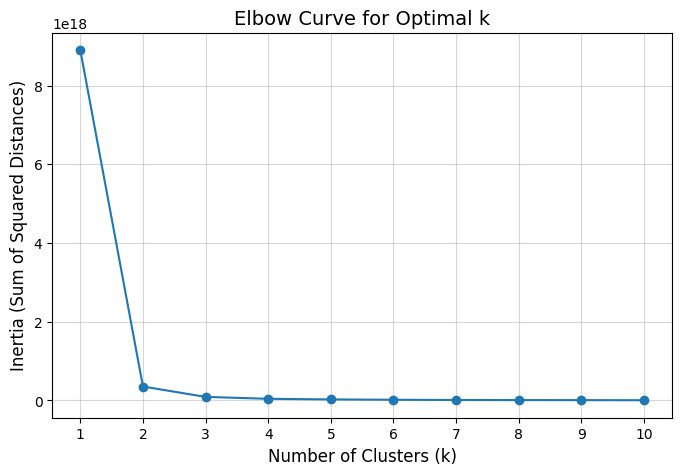

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Define a range of k values
k_range = range(1, 11)  # Testing k from 1 to 10
inertia = []

# Step 2: Fit K-Means for each k and store the inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)  # Replace X_train with your dataset
    inertia.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Curve for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Sum of Squared Distances)', fontsize=12)
plt.xticks(k_range)
plt.grid(alpha=0.5)
plt.show()


In [ ]:
# ROC-AUC score
roc_auc = roc_auc_score(y_test, model.decision_function(X_test))
print(f"ROC-AUC Score: {roc_auc:.2f}")

ROC-AUC Score: 0.89


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(



# Step 6: Visualize Anomalies in Time Series

In [ ]:

import matplotlib.pyplot as plt

# Add predictions to test set for visualization
X_test['Anomaly'] = y_pred
X_test['Actual'] = y_test.values

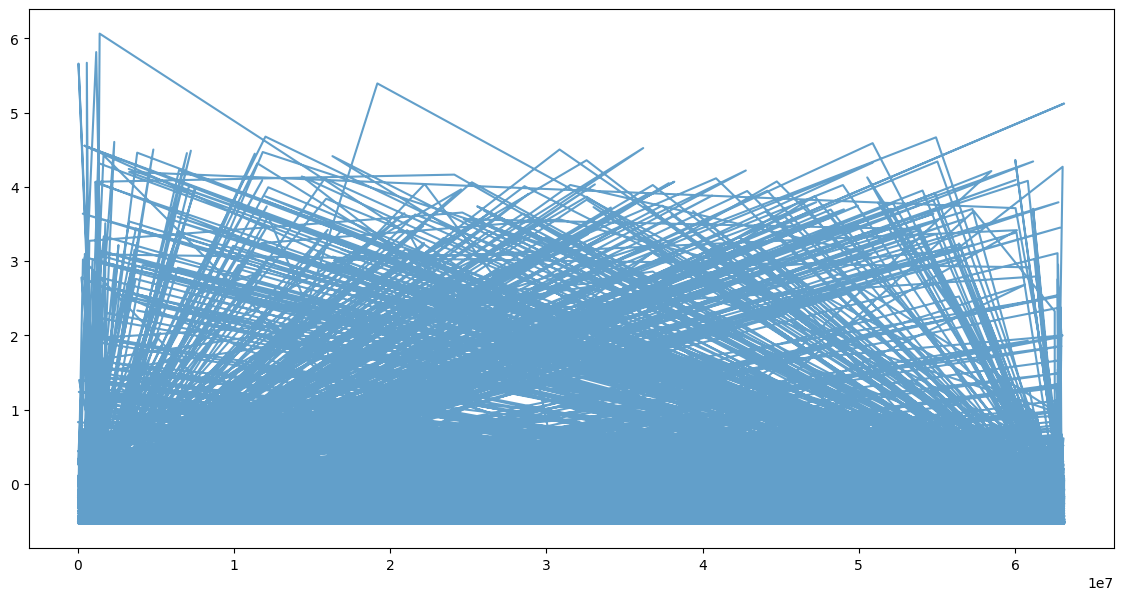

In [ ]:
# Plot time series with anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(X_test['time_seconds'], X_test['amt'], label='Normal Data', alpha=0.7)

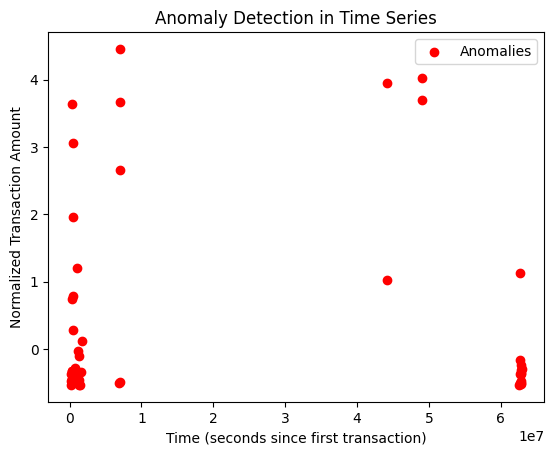

In [ ]:
# Highlight anomalies
anomalies = X_test[X_test['Anomaly'] == 1]
plt.scatter(anomalies['time_seconds'], anomalies['amt'], color='red', label='Anomalies')

plt.title("Anomaly Detection in Time Series")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Normalized Transaction Amount")
plt.legend()
plt.show()

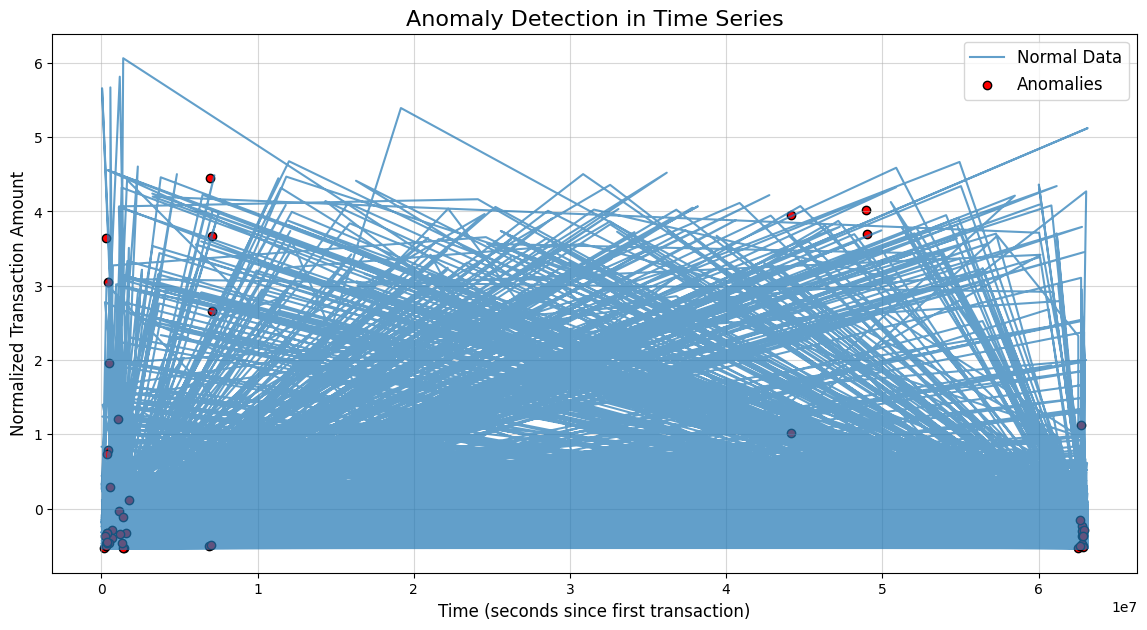

In [ ]:
import matplotlib.pyplot as plt

# Separate normal and anomalous data
normal_data = X_test[X_test['Anomaly'] == 0]
anomaly_data = X_test[X_test['Anomaly'] == 1]

# Plot time series with anomalies highlighted
plt.figure(figsize=(14, 7))

# Plot normal data
plt.plot(
    normal_data['time_seconds'],
    normal_data['amt'],
    linestyle='-',
    alpha=0.7,
    label='Normal Data'
)

# Highlight anomalies
plt.scatter(
    anomaly_data['time_seconds'],
    anomaly_data['amt'],
    color='red',
    label='Anomalies',
    edgecolor='k'
)

# Add labels, title, and legend
plt.title("Anomaly Detection in Time Series", fontsize=16)
plt.xlabel("Time (seconds since first transaction)", fontsize=12)
plt.ylabel("Normalized Transaction Amount", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)

# Show plot
plt.show()


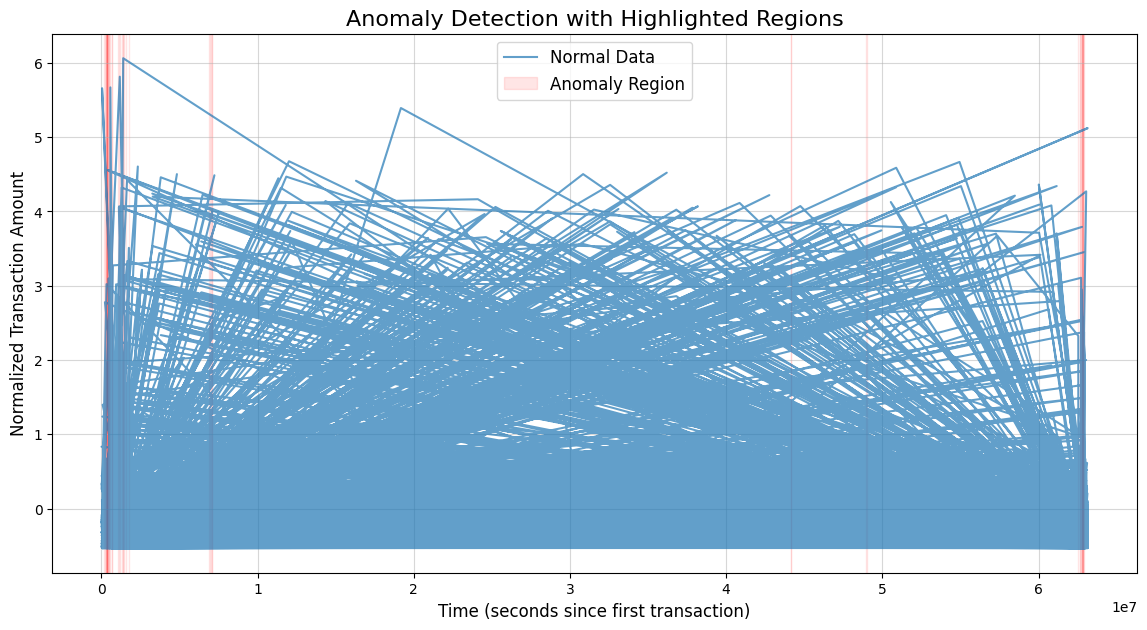

In [ ]:
# Plot with shaded anomaly regions
plt.figure(figsize=(14, 7))

# Plot normal data
plt.plot(
    normal_data['time_seconds'],
    normal_data['amt'],
    linestyle='-',
    alpha=0.7,
    label='Normal Data'
)

# Highlight anomalies with shaded regions
for _, row in anomaly_data.iterrows():
    plt.axvspan(
        row['time_seconds'] - 50,  # Extend shading slightly before anomaly
        row['time_seconds'] + 50,  # Extend shading slightly after anomaly
        color='red',
        alpha=0.1
    )

# Add labels, title, and legend
plt.title("Anomaly Detection with Highlighted Regions", fontsize=16)
plt.xlabel("Time (seconds since first transaction)", fontsize=12)
plt.ylabel("Normalized Transaction Amount", fontsize=12)
plt.legend(['Normal Data', 'Anomaly Region'], fontsize=12)
plt.grid(alpha=0.5)

# Show plot
plt.show()


# Summary:

*  Loaded and preprocessed the dataset.
*  Split it into training and testing sets, maintaining class distribution.
*  Use the PyOD library for anomaly detection.
*  Evaluate the detection with classification metrics and ROC-AUC.
*  Visualize the anomalies on a time series plot for interpretability.





